In [1]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo

from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness_new import calculate_completeness_of_objects
from mass_function import get_weighted_mass_histogram, get_region_volume
from constants import MASS_BINS, Z_MAX, LOG_MASS_LUMINOSITY_RATIO_BINS
from richard_curve import get_mass_luminosity_cutoff, get_distance_from_mass, filter_for_richards_curve, get_mass_luminosity_histogram
from constants import MASS_BINS, Z_MAX, LOG_MASS_LUMINOSITY_RATIO_BINS

In [2]:
GAMA_Full_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data
GAMA_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/gkvscienceStellarmass_Morphology/fullmerged_gkvscienceStellarmass_Morphologyv02_shrinked.fits')[1].data #galaxy

SDSS_Full_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/SDSS/SDSS_DR7/SDSS_DR7.fits')[1].data  #galaxy #todo: find the full and spectroscopic with mass estimation files.
SDSS_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/SDSS/SDSS_DR7/SDSS_DR7.fits')[1].data  #galaxy

# eFEDS = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eFEDS/Mathias_Klug/efeds_members.fit')[1].data    #todo: check of efeds is deeper than erass1
eRASS1 = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eRASS/merged_primary&optical_clusters/merged_optical_primary_clusters.fits')[1].data #cluster

In [3]:
# load the galaxy data from the fits object into dataframes

# the full survey doesnt have the cool extra parameters but it doesnt need them
gama_full_raw_df_unmasked = pd.DataFrame({
        'uberID': GAMA_Full_raw['uberID'].byteswap().newbyteorder(),
        'uberclass': GAMA_Full_raw['uberclass'].byteswap().newbyteorder(),
        'RA': GAMA_Full_raw['RAcen'].byteswap().newbyteorder(),
        'DEC': GAMA_Full_raw['Deccen'].byteswap().newbyteorder(),
        'z': GAMA_Full_raw['Z'].byteswap().newbyteorder(),
        'duplicate': GAMA_Full_raw['duplicate'].byteswap().newbyteorder(),
        'mask': GAMA_Full_raw['mask'].byteswap().newbyteorder(),
        'starmask': GAMA_Full_raw['starmask'].byteswap().newbyteorder(),
        'flux': GAMA_Full_raw['flux_rt'].byteswap().newbyteorder(),
})

# the small survey has all the extra parameters
gama_df_unmasked = pd.DataFrame({
    'uberID': GAMA_raw['uberID'].byteswap().newbyteorder(),
    'RA': GAMA_raw['RAcen'].byteswap().newbyteorder(),
    'DEC': GAMA_raw['Deccen'].byteswap().newbyteorder(),
    'z': GAMA_raw['Z'].byteswap().newbyteorder(),
    'mstar': GAMA_raw['mstar'].byteswap().newbyteorder(),
    'flux': GAMA_raw['flux_rt'].byteswap().newbyteorder(),
    'log_age': GAMA_raw['logage'].byteswap().newbyteorder(),
    'log_met': GAMA_raw['logtau'].byteswap().newbyteorder(),
    'log_met': GAMA_raw['logmet'].byteswap().newbyteorder(),
    'morphology': GAMA_raw['FINAL_CLASS'].byteswap().newbyteorder(),
    'uberclass': GAMA_raw['uberclass'].byteswap().newbyteorder(),  # Add missing columns
    'duplicate': GAMA_raw['duplicate'].byteswap().newbyteorder(),
    'mask': GAMA_raw['mask'].byteswap().newbyteorder(),
    'starmask': GAMA_raw['starmask'].byteswap().newbyteorder(),
    'NQ': GAMA_raw['NQ'].byteswap().newbyteorder(),
})

# Remove rows where flux is NaN in both dataframes
gama_full_raw_df_unmasked = gama_full_raw_df_unmasked[gama_full_raw_df_unmasked['flux'].notna()]
gama_df_unmasked = gama_df_unmasked[gama_df_unmasked['flux'].notna()]
gama_df_unmasked['comoving_distance'] = cosmo.comoving_distance(gama_df_unmasked['z']).value






# load the clusters of galaxies data from the fits object into dataframes
cluster_df_raw = pd.DataFrame({
    'c_ID': eRASS1['DETUID'].byteswap().newbyteorder(),
    'c_NAME': eRASS1['NAME'].byteswap().newbyteorder(),
    'RA': eRASS1['RA'].byteswap().newbyteorder(),
    'DEC': eRASS1['DEC'].byteswap().newbyteorder(),
    'z': eRASS1['BEST_Z'].byteswap().newbyteorder(),
    'cluster_radius_kpc': eRASS1['R500'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': eRASS1['VDISP_BOOT'].byteswap().newbyteorder(),
})

In [4]:
# Masks
# GALAXIES

# BIG GALAXY
# Apply the masks to the GAMA big DataFrame
gama_full_df = gama_full_raw_df_unmasked[
    (gama_full_raw_df_unmasked['uberclass'] == 1) &  # Classified as galaxy
    (gama_full_raw_df_unmasked['duplicate'] == 0) &  # Unique object
    (gama_full_raw_df_unmasked['mask'] == False) &   # Not masked
    (gama_full_raw_df_unmasked['starmask'] == False) &  # Not star-masked
    (gama_full_raw_df_unmasked['z'] < 0.4) &         # Redshift less than 0.4
    (
        ((gama_full_raw_df_unmasked['RA'] > 129.0) & (gama_full_raw_df_unmasked['RA'] < 141.0) & (gama_full_raw_df_unmasked['DEC'] > -2.0) & (gama_full_raw_df_unmasked['DEC'] < 3.0)) |
        ((gama_full_raw_df_unmasked['RA'] > 174.0) & (gama_full_raw_df_unmasked['RA'] < 186.0) & (gama_full_raw_df_unmasked['DEC'] > -3.0) & (gama_full_raw_df_unmasked['DEC'] < 2.0)) |
        ((gama_full_raw_df_unmasked['RA'] > 211.5) & (gama_full_raw_df_unmasked['RA'] < 223.5) & (gama_full_raw_df_unmasked['DEC'] > -2.0) & (gama_full_raw_df_unmasked['DEC'] < 3.0)) |
        ((gama_full_raw_df_unmasked['RA'] > 339.0) & (gama_full_raw_df_unmasked['RA'] < 351.0) & (gama_full_raw_df_unmasked['DEC'] > -35.0) & (gama_full_raw_df_unmasked['DEC'] < -30.0))
    ) &
    (gama_full_raw_df_unmasked['flux'] >= 5.011928e-05)  # Flux greater than or equal to 5.011928e-05
]



# SMALL GALAXY survey masks
gama_small_mask = (
    (gama_df_unmasked['uberclass'] == 1) &           # Classified as galaxy
    (gama_df_unmasked['duplicate'] == 0) &           # Unique object
    (gama_df_unmasked['mask'] == False) &            # Not masked
    (gama_df_unmasked['starmask'] == False) &        # Not star-masked
    (gama_df_unmasked['mstar'] > 0) &                # Stellar mass greater than 0
    (gama_df_unmasked['NQ'] > 2) &                   # Reliable redshift
    (gama_df_unmasked['z'] != 0) &                   # Redshift not zero
    (gama_df_unmasked['z'] != -9.999) &              # Redshift not -9.999 (invalid value)
    (gama_df_unmasked['z'] < Z_MAX) &                # Redshift less than Z_MAX (define Z_MAX)
    (
        ((gama_df_unmasked['RA'] > 129.0) & (gama_df_unmasked['RA'] < 141.0) & (gama_df_unmasked['DEC'] > -2.0) & (gama_df_unmasked['DEC'] < 3.0)) |
        ((gama_df_unmasked['RA'] > 174.0) & (gama_df_unmasked['RA'] < 186.0) & (gama_df_unmasked['DEC'] > -3.0) & (gama_df_unmasked['DEC'] < 2.0)) |
        ((gama_df_unmasked['RA'] > 211.5) & (gama_df_unmasked['RA'] < 223.5) & (gama_df_unmasked['DEC'] > -2.0) & (gama_df_unmasked['DEC'] < 3.0)) |
        ((gama_df_unmasked['RA'] > 339.0) & (gama_df_unmasked['RA'] < 351.0) & (gama_df_unmasked['DEC'] > -35.0) & (gama_df_unmasked['DEC'] < -30.0))
    ) &
    (gama_df_unmasked['flux'] >= 5.011928e-05)       # Flux greater than or equal to 5.011928e-05
)

# Apply the mask
gama_df = gama_df_unmasked[gama_small_mask]







# CLUSTERS
# Remove rows where 'cluster_Velocity_Dispersion' is NaN
cluster_df_noVelDisp = cluster_df_raw.dropna(subset=['cluster_Velocity_Dispersion'])

cluster_masks = (
    (cluster_df_noVelDisp['z'] <= 0.4) &
    (
        ((cluster_df_noVelDisp['RA'] > 129.0) & (cluster_df_noVelDisp['RA'] < 141.0) & (cluster_df_noVelDisp['DEC'] > -2.0) & (cluster_df_noVelDisp['DEC'] < 3.0)) |
        ((cluster_df_noVelDisp['RA'] > 174.0) & (cluster_df_noVelDisp['RA'] < 186.0) & (cluster_df_noVelDisp['DEC'] > -3.0) & (cluster_df_noVelDisp['DEC'] < 2.0)) |
        ((cluster_df_noVelDisp['RA'] > 211.5) & (cluster_df_noVelDisp['RA'] < 223.5) & (cluster_df_noVelDisp['DEC'] > -2.0) & (cluster_df_noVelDisp['DEC'] < 3.0)) |
        ((cluster_df_noVelDisp['RA'] > 339.0) & (cluster_df_noVelDisp['RA'] < 351.0) & (cluster_df_noVelDisp['DEC'] > -35.0) & (cluster_df_noVelDisp['DEC'] < -30.0))
    ) &

    (cluster_df_noVelDisp['cluster_radius_kpc'] != -1)
)

# Apply the mask to the DataFrame to create the final filtered DataFrame
cluster_df = cluster_df_noVelDisp[cluster_masks]
cluster_df['cluster_radius_Mpc'] = cluster_df['cluster_radius_kpc'] / 1000

/tmp/ipykernel_574363/2353574307.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['cluster_radius_Mpc'] = cluster_df['cluster_radius_kpc'] / 1000


In [5]:
print(len(cluster_df))

60


In [6]:
# Assuming you have all necessary imports and the constants file loaded correctly
gama_df = calculate_completeness_of_objects(gama_full_df, gama_df)

/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/completeness_new.py:23: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/completeness_new.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_survey["completeness"] = object_completeness


In [7]:
matched_gama_dataframe = match_galaxies_and_clusters(galaxy_dataframe=gama_df.head(1000), cluster_dataframe=cluster_df.head(10))
matched_gama_dataframe.to_csv('gama_matched_in_erass1.csv')

Progress: 10.299999999999999%

/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/galaxy_cluster_matching.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galaxy_dataframe['environment'] = "Field"
/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/galaxy_cluster_matching.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galaxy_dataframe['cluster_mass'] = None
/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/galaxy_cluster_matching.py:42: Se

Progress: 100.4%999999999998%

/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/galaxy_cluster_matching.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galaxy_dataframe.at[i, 'cluster_radius'] = cluster['cluster_radius_Mpc']


In [8]:
# load matched galaxies
gama_df = pd.read_csv('gama_matched_in_erass1.csv')

In [14]:
# apply selection function
mass_to_light_histogram_all_galaxies = get_mass_luminosity_histogram(galaxy_df=gama_df)
mass_to_light_histogram_low_mass_galaxies = get_mass_luminosity_histogram(galaxy_df=gama_df[gama_df["mstar"] < 10**10])
mass_luminosity_cutoff = get_mass_luminosity_cutoff(gama_df, cut_off_percentage=80)
mass_bin_selection_function = np.logspace(5,12.25, 1000)
# mass_for_richards_curve = np.logspace(5,12.25, 1000)
richards_curve = get_distance_from_mass(mass_bin_selection_function, log_cutoff_mass_to_light_ratio=mass_luminosity_cutoff)
gama_df['within_richards_curve'] = gama_df.apply(lambda row: filter_for_richards_curve(richards_curve, mass_bin_selection_function, row['mstar'], row['comoving_distance']), axis=1)

/tmp/ipykernel_574363/4110235120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gama_df['within_richards_curve'] = gama_df.apply(lambda row: filter_for_richards_curve(richards_curve, mass_bin_selection_function, row['mstar'], row['comoving_distance']), axis=1)


In [15]:
# find the general mass function
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(gama_df[gama_df['within_richards_curve']], region_name='G09')
stellar_mass_function = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

In [16]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 18,           # Font size for text
    'axes.titlesize': 18,      # Font size for axes titles
    'axes.labelsize': 16,      # Font size for x and y labels
    'xtick.labelsize': 16,     # Font size for x tick labels
    'ytick.labelsize': 16,     # Font size for y tick labels
    'legend.fontsize': 16,     # Font size for legend text
    'figure.figsize': (15, 8), # Default figure size
    'text.usetex': False
})

Text(0, 0.5, 'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')

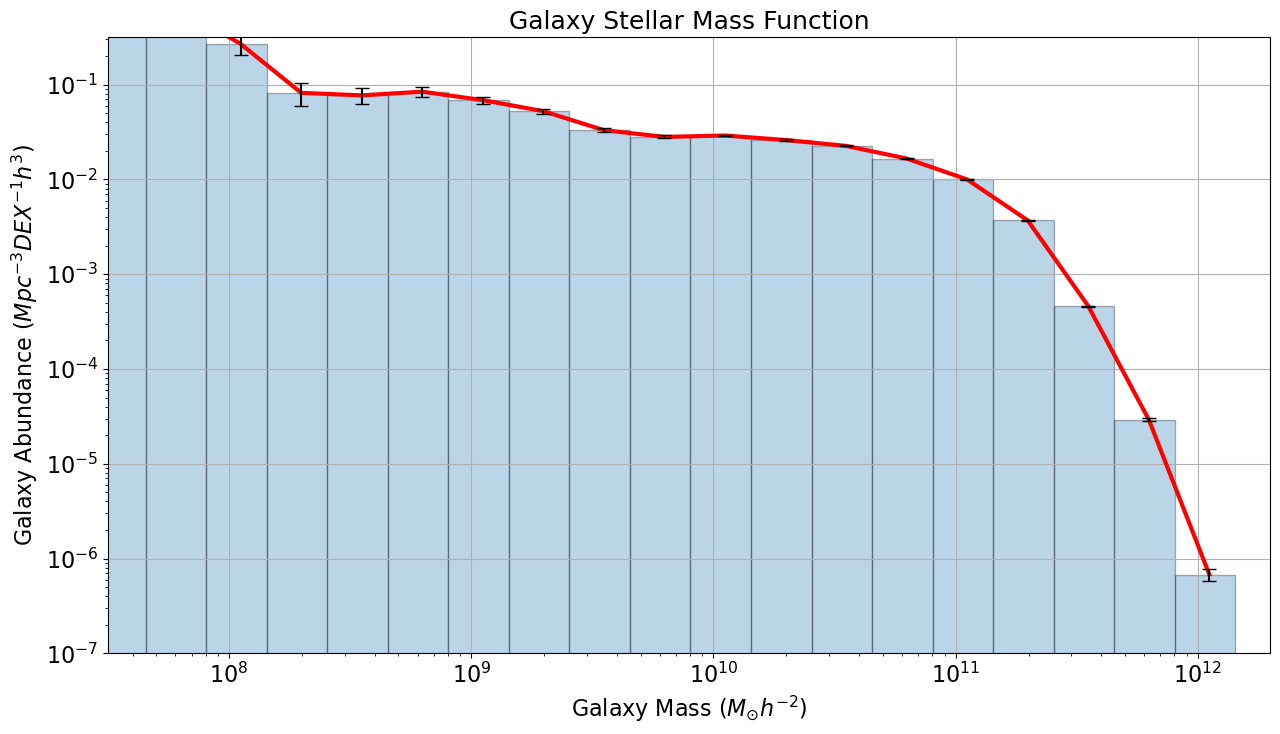

In [17]:
# plot the general mass function

bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers / 0.7, stellar_mass_function * 0.7**3, width=np.diff(MASS_BINS) / 0.7, edgecolor='black', capsize=5, alpha=0.3)

plt.plot(bin_centers[10:] / 0.7, stellar_mass_function[10:] * 0.7**3, color='red', linewidth=3, label="This Work z < 0.4")
plt.bar(bin_centers / 0.7, stellar_mass_function * 0.7**3, width=np.diff(MASS_BINS) / 0.7, edgecolor='black', yerr=stellar_mass_function_error * 0.7**3, capsize=5, alpha=0.0)

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.5, 10**12.3)
plt.ylim(10**-7, 10**-0.5)
plt.grid()

plt.title("Galaxy Stellar Mass Function")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
# plt.savefig("../plots/mass_function_alone.pdf")